In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)

In [4]:
def export_csv():
    # Left lower extremity
    res = {}
    #path = 'F:\\IDM_Downloads\\GaitRec\\'
    # Left lower extremity
    #res['GRF_F_V_PRO_left'] = pd.read_csv(r'GRF_F_V_PRO_left.csv')

    #res['GRF_F_AP_PRO_left'] = pd.read_csv(r'GRF_F_AP_PRO_left.csv')

    #res['GRF_F_ML_PRO_left'] = pd.read_csv(r'GRF_F_ML_PRO_left.csv')

    #res['GRF_COP_AP_PRO_left'] = pd.read_csv(r'GRF_COP_AP_PRO_left.csv')

    #res['GRF_COP_ML_PRO_left'] = pd.read_csv(r'GRF_COP_ML_PRO_left.csv')

    # Right lower extremity
    #res['GRF_F_V_PRO_right'] = pd.read_csv(r'GRF_F_V_PRO_right.csv')

    #res['GRF_F_AP_PRO_right'] = pd.read_csv(r'GRF_F_AP_PRO_right.csv')

    res['GRF_F_ML_PRO_right'] = pd.read_csv(r'GRF_F_ML_PRO_right.csv')

    #res['GRF_COP_AP_PRO_right'] = pd.read_csv(r'GRF_COP_AP_PRO_right.csv')

    #res['GRF_COP_ML_PRO_right'] = pd.read_csv(r'F:\\IDM_Downloads\\GaitRec\\GRF_COP_ML_PRO_right.csv')

    # Annotations and Metadata
    res['GRF_Annotation'] = pd.read_csv(r'GRF_metadata.csv')
    return res

In [5]:
df_dict = export_csv()

In [7]:
lstm_autoencoder_right = tf.keras.models.load_model('outputs/lstm_auto_080121_right_ML_84816en.h5')
#autoencoder_left = tf.keras.models.load_model('outputs/lstm_auto_080121_left_ML_84816en.h5')

In [9]:
#lstm_autoencoder_left.summary()
lstm_autoencoder_right.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 16, 16)            1152      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16, 8)             800       
_________________________________________________________________
lstm_7 (LSTM)                (None, 4)                 208       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 16, 4)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 16, 8)             416       
_________________________________________________________________
lstm_9 (LSTM)                (None, 16, 16)            1600      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 1)            

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [10]:
def get_data_series(X_data, serie_size):
    #first_step = 0 #X_data.shape[1] - serie_size - 1
    #print(X_data.shape)
    last_step = X_data.shape[1]
    data_series = []
    for row in X_data:
        for step1 in range(last_step - serie_size):
            serie = row[step1 : step1 + serie_size]
            # for step2 in range(serie_size):
            #     serie.append(row[step1 + step2])
            data_series.append(serie)
    res = np.array(np.squeeze(np.array(data_series)))
    #print(res.shape)
    return res

In [11]:
def get_Inputs(grf, meta, label):
    subject_id = meta.loc[meta["CLASS_LABEL"]==label]["SUBJECT_ID"].unique()
    subject_id = pd.DataFrame({"SUBJECT_ID": subject_id})
    grf = subject_id.merge(grf, on="SUBJECT_ID", how = "inner")
    #grf = grf.drop_duplicates(['SUBJECT_ID'], keep = 'first')
    grf.drop(grf.columns[:3], axis = 1)
    res = np.array(grf)
    return res

In [12]:
def get_all_sensor_data(label):
    X_data = None
    for key in df_dict:
        if key== 'GRF_Annotation': 
            continue
        temp = get_Inputs(df_dict[key], df_dict['GRF_Annotation'], label)
        if X_data is None:
            X_data = temp
        else:
            X_data = np.append(X_data, temp, axis=0)
    return X_data

In [13]:
df_dict['GRF_Annotation'].head()

,SUBJECT_ID,SESSION_ID,CLASS_LABEL,CLASS_LABEL_DETAILED,SEX,AGE,HEIGHT,BODY_WEIGHT,BODY_MASS,SHOE_SIZE,AFFECTED_SIDE,SHOD_CONDITION,ORTHOPEDIC_INSOLE,SPEED,READMISSION,SESSION_TYPE,SESSION_DATE,TRAIN,TRAIN_BALANCED,TEST
0,1,29885,HC,HC,1,18,173.0,516.1,52.6,42.0,NaN,1,0.0,2,0,1,29.01.2015,0,0,1
1,1,29886,HC,HC,1,18,173.0,516.2,52.6,42.0,NaN,1,0.0,1,0,1,29.01.2015,0,0,1
2,1,29888,HC,HC,1,18,173.0,516.1,52.6,42.0,NaN,1,0.0,3,0,1,29.01.2015,0,0,1
3,2,888812549,HC,HC,1,51,182.0,752.1,76.7,44.0,NaN,1,0.0,1,0,1,03.08.2017,1,0,0
4,2,888812550,HC,HC,1,51,182.0,752.4,76.7,44.0,NaN,1,0.0,3,0,1,03.08.2017,1,0,0


In [14]:
df_dict['GRF_Annotation'].loc[df_dict['GRF_Annotation']["SUBJECT_ID"]==1087]

,SUBJECT_ID,SESSION_ID,CLASS_LABEL,CLASS_LABEL_DETAILED,SEX,AGE,HEIGHT,BODY_WEIGHT,BODY_MASS,SHOE_SIZE,AFFECTED_SIDE,SHOD_CONDITION,ORTHOPEDIC_INSOLE,SPEED,READMISSION,SESSION_TYPE,SESSION_DATE,TRAIN,TRAIN_BALANCED,TEST
4034,1087,12046,K,K_PFR,1,46,NaN,830.9,84.7,NaN,1.0,1,0.0,2,0,2,21.01.2010,1,0,0


In [15]:
def get_box_plot_list(lable, model, keys) :
    top = []
    middel = []
    last = []
    meta = df_dict['GRF_Annotation']
    for key in keys:
        grf = df_dict[key]
        subject_id = meta.loc[meta["CLASS_LABEL"]==lable]["SUBJECT_ID"].unique()
        grf = (pd.DataFrame({"SUBJECT_ID": subject_id})).merge(grf, on="SUBJECT_ID", how = "inner")
        for id in subject_id:
            session_id = meta.loc[meta["SUBJECT_ID"]==id]["SESSION_ID"].unique()
            if len(session_id)<5:
                continue
            #first
            temp_X = None
            temp_X = grf.loc[grf["SESSION_ID"]==session_id[0]]
            temp_X = temp_X.iloc[:,3:].values
            temp_X = scaler.fit_transform(temp_X)
            temp_X = get_data_series(temp_X, 16)
            temp_X = temp_X.reshape(temp_X.shape[0], temp_X.shape[1], 1)
            valid_x_predictions = model.predict(temp_X)
            top.append(np.mean(np.power(temp_X - valid_x_predictions, 2)))
            #last
            temp_X = grf.loc[grf["SESSION_ID"]==session_id[-1]]
            temp_X = temp_X.iloc[:,3:].values
            temp_X = scaler.fit_transform(temp_X)
            temp_X = get_data_series(temp_X, 16)
            temp_X = temp_X.reshape(temp_X.shape[0], temp_X.shape[1], 1)
            valid_x_predictions = model.predict(temp_X)
            last.append(np.mean(np.power(temp_X - valid_x_predictions, 2)))
            #middle
            if len(session_id)%2 == 0:
                temp_X = grf.loc[grf["SESSION_ID"]==session_id[len(session_id)//2]]
                temp_X = temp_X.iloc[:,3:].values
                temp_X = scaler.fit_transform(temp_X)
                temp_X = get_data_series(temp_X, 16)
                temp_X = temp_X.reshape(temp_X.shape[0], temp_X.shape[1], 1)
                valid_x_predictions = model.predict(temp_X)
                middel.append(np.mean(np.power(temp_X - valid_x_predictions, 2)))

                temp_X = grf.loc[grf["SESSION_ID"]==session_id[len(session_id)//2+1]]
                temp_X = temp_X.iloc[:,3:].values
                temp_X = scaler.fit_transform(temp_X)
                temp_X = get_data_series(temp_X, 16)
                temp_X = temp_X.reshape(temp_X.shape[0], temp_X.shape[1], 1)
                valid_x_predictions = model.predict(temp_X)
                middel[-1] = (middel[-1] + np.mean(np.power(temp_X - valid_x_predictions, 2)))/2
            else:
                temp_X = grf.loc[grf["SESSION_ID"]==session_id[len(session_id)//2]]
                temp_X = temp_X.iloc[:,3:].values
                temp_X = scaler.fit_transform(temp_X)
                temp_X = get_data_series(temp_X, 16)
                temp_X = temp_X.reshape(temp_X.shape[0], temp_X.shape[1], 1)
                valid_x_predictions = model.predict(temp_X)
                middel.append(np.mean(np.power(temp_X - valid_x_predictions, 2)))
    return top, middel, last

In [16]:
#left_leg_sensors = ['GRF_F_ML_PRO_left']#, 'GRF_F_AP_PRO_left', 'GRF_F_ML_PRO_left', 'GRF_COP_AP_PRO_left', 'GRF_COP_ML_PRO_left']
right_leg_sensors = ['GRF_F_ML_PRO_right']#, 'GRF_F_AP_PRO_right', 'GRF_F_ML_PRO_right', 'GRF_COP_AP_PRO_right', 'GRF_COP_ML_PRO_right']
class_labels = ['A']

In [17]:
def rej_fliers_iqr(seq, rng=0.99):#rejects the outliers outside iqr range
    percent = (1 - rng) / 2
    iqr_low, median, iqr_high = seq.dropna().quantile([percent, 0.50, 1-percent])
    iqr = iqr_high - iqr_low
    return seq[ (seq - median).abs() <= iqr]

In [18]:
def getTitle(label):
    if label=="HC":
        return "Healthy Controls"
    elif label=="K":
        return "Knee impairment "
    elif label=="A":
        return "Ankle impairment"
    elif label=="H":
        return "Hip impairment"
    else:
        return "Calcaneus impairment"

In [19]:
import matplotlib

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
#matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
A : 0.0055578040802152 0.0032718677346735324 0.002676683823086553


<Figure size 1440x1440 with 0 Axes>

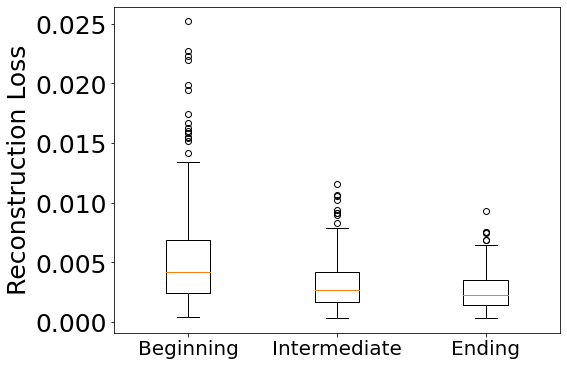

In [20]:
for label in class_labels:
        top, middle, last = get_box_plot_list(label, lstm_autoencoder_right, right_leg_sensors)
        top = rej_fliers_iqr(pd.Series(top), 0.9)
        middle = rej_fliers_iqr(pd.Series(middle), 0.9)
        last = rej_fliers_iqr(pd.Series(last), 0.9)
        data = [top, middle, last]
        data_m_start = np.mean(top)
        data_m_intr = np.mean(middle)
        data_m_end = np.mean(last)
        print(label, ":", data_m_start, data_m_intr, data_m_end)
        plt.figure(figsize= (20,20))
        fig, ax = plt.subplots()
        #ax.set_title('class {} - Left lower extremity'.format(getTitle(label)))
        ax.boxplot(data)
        ax.set_ylabel('Reconstruction Loss')
        ax.set_xticklabels(['Beginning', 'Intermediate', 'Ending'])
        file_nm = 'new_right_ML_corrected'+format(getTitle(label))+'90.png'
        plt.savefig(file_nm, bbox_inches='tight', dpi= 100)
        plt.show()

In [ ]:
V-axis
K : 0.004203931532116741 0.0027187922548652086 0.0023142402479408536
H : 0.003743144061146375 0.002838597063534366 0.0024257035708507403
C : 0.004534915612131504 0.0032654907452677163 0.0029463954703972408
A : 0.004769678867149032 0.0029827835656612233 0.002499888428051085

In [ ]:
AP-axis
K : 0.015564994924309985 0.005382152256299727 0.004699649301234361
H : 0.00889807287670535 0.00770652381535333 0.007429436210450744
C : 0.017456559517862964 0.009766333014906503 0.00653961885459654
A : 0.021064550182801414 0.008478778854736245 0.004968113423332842

In [ ]:
ML-axis
K : 0.004820188951921757 0.003050621204872957 0.0024792297157890902
H : 0.004645596100502807 0.0031631918017256955 0.00330515084819569
C : 0.004889341988670792 0.00335390864454166 0.0030677796963494678
A : 0.0055578040802152 0.0032718677346735324 0.002676683823086553

## Left leg

In [ ]:
K : 0.007301199643341826 0.005075070521412267 0.004374455444301689
H : 0.006344398349575069 0.0048767410754657235 0.004496738069718985
C : 0.007917562837540219 0.005635572509540336 0.005210821493519432
A : 0.008401518493262608 0.005422690289014202 0.0046893195474335654

In [ ]:
K : 0.001882273842528965 0.001312826954445924 0.0010344295600090549
H : 0.0016917782286104551 0.0013775422271015913 0.0012798317006529204
C : 0.002746792721282349 0.0016561505221276203 0.001399190236066947
A : 0.002555248992832136 0.0014502252148502696 0.001240992359587252

In [ ]:
K : 0.0045815316056232 0.0031372146465102327 0.002524609351882927
H : 0.004770618693849513 0.003225426438885901 0.002919982621207497
C : 0.004955924070916176 0.0030663415423425504 0.0031416563778904174
A : 0.005857915697822267 0.0032594619550579147 0.0028257830225461027